In [1]:
# --------------------------
# 1. 필요한 라이브러리 설치
# --------------------------


print("🚀 라이브러리 설치 시작!")
!pip install yfinance pandas matplotlib duckdb streamlit fredapi pyngrok --quiet
print("✅ 라이브러리 설치 완료!")

🚀 라이브러리 설치 시작!
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 43.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 42.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 4.3 MB/s eta 0:00:00
✅ 라이브러리 설치 완료!


In [2]:
# --------------------------
# 2. 데이터 수집
# --------------------------

print("\n🚀 데이터 수집 시작!")

import pandas as pd
import yfinance as yf
from fredapi import Fred

FRED_API_KEY = '여기에 본인 API 키 입력'
fred = Fred(api_key=FRED_API_KEY)

print("\n📥 미국 GDP 데이터 수집 중 (FRED)...")
gdp_series = fred.get_series('GDP')
gdp_data = gdp_series.reset_index()
gdp_data.columns = ['Date', 'GDP']
gdp_data['Date'] = pd.to_datetime(gdp_data['Date'])
gdp_data = gdp_data.sort_values('Date')
print("✅ FRED GDP 데이터 수집 완료! 총 데이터 포인트:", len(gdp_data))
print(gdp_data.tail())

print("\n📥 미국 전체 시가총액 데이터 수집 중 (Yahoo Finance)...")
wilshire = yf.Ticker("^W5000")
market_cap_data = wilshire.history(period="max")
market_cap_data = market_cap_data[['Close']].rename(columns={'Close': 'Market_Cap'})
market_cap_data['Date'] = market_cap_data.index
market_cap_data.reset_index(drop=True, inplace=True)
print("✅ Yahoo Finance 시가총액 데이터 수집 완료! 총 데이터 포인트:", len(market_cap_data))
print(market_cap_data.tail())


🚀 데이터 수집 시작!

📥 미국 GDP 데이터 수집 중 (FRED)...
✅ FRED GDP 데이터 수집 완료! 총 데이터 포인트: 316
          Date        GDP
311 2023-10-01  28296.967
312 2024-01-01  28624.069
313 2024-04-01  29016.714
314 2024-07-01  29374.914
315 2024-10-01  29723.864

📥 미국 전체 시가총액 데이터 수집 중 (Yahoo Finance)...
✅ Yahoo Finance 시가총액 데이터 수집 완료! 총 데이터 포인트: 9135
        Market_Cap                      Date
9130  53283.019531 2025-04-11 00:00:00-04:00
9131  53722.269531 2025-04-14 00:00:00-04:00
9132  53652.519531 2025-04-15 00:00:00-04:00
9133  52523.339844 2025-04-16 00:00:00-04:00
9134  52644.738281 2025-04-17 00:00:00-04:00


In [3]:
# --------------------------
# 3. DuckDB 저장
# --------------------------
print("\n🚀 DuckDB 데이터베이스 저장 시작!")

import duckdb

con = duckdb.connect(database='buffett_indicator.duckdb', read_only=False)

print("📦 GDP 데이터 DuckDB 저장 중...")
con.execute("CREATE TABLE IF NOT EXISTS gdp_data AS SELECT * FROM gdp_data")

print("📦 시가총액 데이터 DuckDB 저장 중...")
con.execute("CREATE TABLE IF NOT EXISTS market_cap_data AS SELECT * FROM market_cap_data")

print("✅ DuckDB 저장 완료! 저장된 데이터 미리보기:")
print(con.execute("SELECT * FROM gdp_data LIMIT 5").fetchdf())
print(con.execute("SELECT * FROM market_cap_data LIMIT 5").fetchdf())


🚀 DuckDB 데이터베이스 저장 시작!
📦 GDP 데이터 DuckDB 저장 중...
📦 시가총액 데이터 DuckDB 저장 중...
✅ DuckDB 저장 완료! 저장된 데이터 미리보기:
        Date      GDP
0 1946-01-01      NaN
1 1946-04-01      NaN
2 1946-07-01      NaN
3 1946-10-01      NaN
4 1947-01-01  243.164
    Market_Cap                      Date
0  2718.590088 1989-01-03 05:00:00+00:00
1  2752.979980 1989-01-04 05:00:00+00:00
2  2760.919922 1989-01-05 05:00:00+00:00
3  2769.389893 1989-01-06 05:00:00+00:00
4  2773.320068 1989-01-09 05:00:00+00:00


In [4]:
print("\n🚀 DuckDB 에서 데이터 불러오기 및 Buffett Indicator 계산 시작!")

# DuckDB 에서 데이터 읽기
gdp_df = con.execute("SELECT * FROM gdp_data").fetchdf()
market_cap_df = con.execute("SELECT * FROM market_cap_data").fetchdf()

# 데이터 전처리
print("📅 데이터 전처리 중...")
gdp_df['Date'] = pd.to_datetime(gdp_df['Date'])
market_cap_df['Date'] = pd.to_datetime(market_cap_df['Date'])

# 🩹 타임존 제거 (market_cap_df)
market_cap_df['Date'] = market_cap_df['Date'].dt.tz_localize(None)

# 날짜 리샘플링 및 보간
gdp_df = gdp_df.set_index('Date').resample('D').ffill().reset_index()
market_cap_df = market_cap_df.set_index('Date').resample('D').ffill().reset_index()

# 병합
print("🔗 데이터 병합 중...")
buffett_df = pd.merge(market_cap_df, gdp_df, on='Date', how='inner')

# Buffett Indicator 계산
buffett_df['Buffett_Indicator'] = (buffett_df['Market_Cap'] / buffett_df['GDP']) * 100

print("✅ Buffett Indicator 계산 완료! 결과 미리보기:")
print(buffett_df.tail())

print("📦 Buffett Indicator 결과 DuckDB 저장 중...")
con.execute("CREATE OR REPLACE TABLE buffett_indicator_data AS SELECT * FROM buffett_df")
print("✅ 저장 완료!")

# DuckDB 연결 종료
con.close()
print("🔒 DuckDB 연결 종료 완료!")


🚀 DuckDB 에서 데이터 불러오기 및 Buffett Indicator 계산 시작!
📅 데이터 전처리 중...
🔗 데이터 병합 중...
✅ Buffett Indicator 계산 완료! 결과 미리보기:
            Date    Market_Cap        GDP  Buffett_Indicator
13051 2024-09-27  57457.468750  29374.914         195.600466
13052 2024-09-28  57418.699219  29374.914         195.468484
13053 2024-09-29  57418.699219  29374.914         195.468484
13054 2024-09-30  57418.699219  29374.914         195.468484
13055 2024-10-01  57636.941406  29723.864         193.907970
📦 Buffett Indicator 결과 DuckDB 저장 중...
✅ 저장 완료!
🔒 DuckDB 연결 종료 완료!



🚀 시각화 시작!


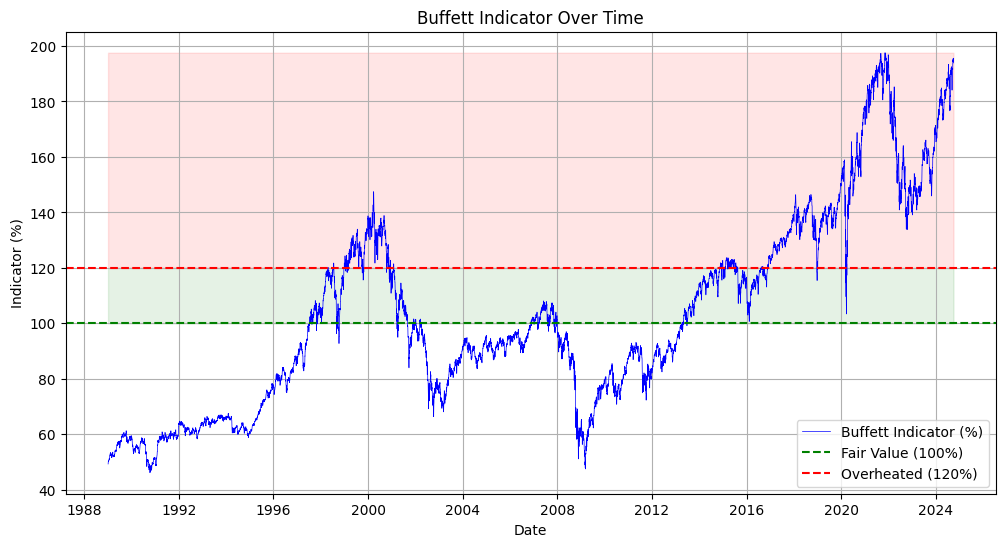

✅ 시각화 완료! Buffett Indicator 의 변화를 시각적으로 확인했습니다.


In [5]:
# --------------------------
# 4. 시각화 (Matplotlib)
# --------------------------
print("\n🚀 시각화 시작!")

import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(buffett_df['Date'], buffett_df['Buffett_Indicator'], label='Buffett Indicator (%)', color='blue', linewidth=0.5)
plt.axhline(y=100, color='green', linestyle='--', label='Fair Value (100%)')
plt.axhline(y=120, color='red', linestyle='--', label='Overheated (120%)')
plt.fill_between(buffett_df['Date'], 100, 120, color='green', alpha=0.1)
plt.fill_between(buffett_df['Date'], 120, buffett_df['Buffett_Indicator'].max(), color='red', alpha=0.1)
plt.title('Buffett Indicator Over Time')
plt.xlabel('Date')
plt.ylabel('Indicator (%)')
plt.legend()
plt.grid(True)
plt.show()

print("✅ 시각화 완료! Buffett Indicator 의 변화를 시각적으로 확인했습니다.")

In [6]:
# =============================
# 5. Streamlit 대시보드 코드 작성
# =============================

print("\n🚀 Streamlit 대시보드 코드 작성 시작!")

streamlit_dashboard_code = """
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt
import duckdb

st.title(\"\U0001F4C8 Buffett Indicator Dashboard\")

# DuckDB 에서 데이터 불러오기
con = duckdb.connect(database='buffett_indicator.duckdb', read_only=True)
buffett_df = con.execute('SELECT * FROM buffett_indicator_data').fetchdf()

st.line_chart(buffett_df.set_index('Date')['Buffett_Indicator'])

st.markdown(\"\"\"
- ✅ **100% 이하:** 시장이 저평가 상태일 수 있음
- 🟡 **100% ~ 120%:** 합리적 수준
- 🔥 **120% 이상:** 시장 과열 구간
\"\"\")

fig, ax = plt.subplots()
ax.plot(buffett_df['Date'], buffett_df['Buffett_Indicator'], label='Buffett Indicator (%)')
ax.axhline(y=100, color='gray', linestyle='--', label='Fair Value (100%)')
ax.axhline(y=120, color='red', linestyle='--', label='Overheated (120%)')
ax.set_xlabel('Date')
ax.set_ylabel('Indicator (%)')
ax.legend()
st.pyplot(fig)
"""

with open("app.py", "w") as file:
    file.write(streamlit_dashboard_code)

print("✅ Streamlit 대시보드 코드가 'buffett_dashboard.py' 로 저장되었습니다!")


🚀 Streamlit 대시보드 코드 작성 시작!
✅ Streamlit 대시보드 코드가 'buffett_dashboard.py' 로 저장되었습니다!


In [8]:
# ngrok으로 공개 URL 생성 (Authtoken 필요)
from pyngrok import ngrok

# 여기에 발급받은 ngrok authtoken 입력하세요!
NGROK_AUTH_TOKEN = "2w1lMu0vDS1pgY2wDQ0d4mJ8IyP_2Jim9cP1bo2r65A59DGmo"
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

print("[INFO] ngrok 터널 생성 중...")
public_url = ngrok.connect(addr="8501", proto="http")
print(f"[INFO] Streamlit 앱 Public URL: {public_url}")

# Streamlit 앱 실행
!streamlit run app.py --server.port 8501 --server.enableCORS false

print("[INFO] Streamlit 웹 서비스가 실행되었습니다. 위의 Public URL을 클릭하여 접속하세요!")

[INFO] ngrok 터널 생성 중...
[INFO] Streamlit 앱 Public URL: NgrokTunnel: "https://0d70-35-189-170-144.ngrok-free.app" -> "http://localhost:8501"
2025-04-22 00:15:07.064 
As a result, 'server.enableCORS' is being overridden to 'true'.

More information:
In order to protect against CSRF attacks, we send a cookie with each request.
To do so, we must specify allowable origins, which places a restriction on
cross-origin resource sharing.

If cross origin resource sharing is required, please disable server.enableXsrfProtection.
            



  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://35.189.170.144:8501

  Stopping...
^C
[INFO] Streamlit 웹 서비스가 실행되었습니다. 위의 Public URL을 클릭하여 접속하세요!
